# Build Wind Turbine with SageMaker

In [3]:
%pip install s3fs 

  Using cached s3fs-2024.6.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
Using cached s3fs-2024.6.1-py3-none-any.whl (29 kB)
Using cached fsspec-2024.6.1-py3-none-any.whl (177 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.20.0 requires fsspec[http]<=2024.5.0,>=2023.1.0, but you have fsspec 2024.6.1 which is incompatible.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.6.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


<Axes: >

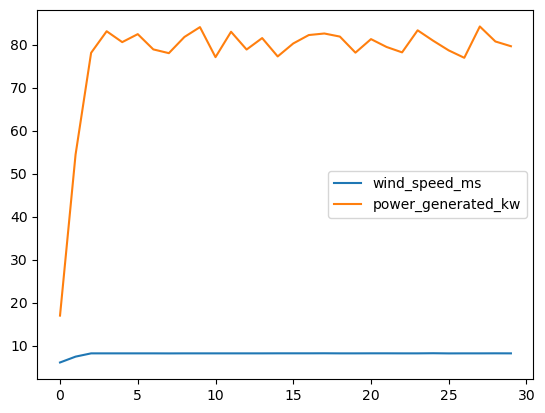

In [4]:
import pandas as pd

input_data = "s3://iiotbook-data/wind_turbine.csv"
df = pd.read_csv(input_data)
df.iloc[0:30].plot()

In [5]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

n_estimators=100

#Split train and test datasets
train_df, test_df = train_test_split(
    df,
    test_size=0.3,
)

# build X,y and train,test datasets 
y_train = train_df.pop("power_generated_kw")
X_train = train_df.values
y_test = test_df.pop("power_generated_kw")
X_test = test_df.values

# build the model
reg = GradientBoostingRegressor(
    n_estimators=n_estimators
)
reg.fit(X_train, y_train)

# test the model
y_pred = reg.predict(X_test)

print(r2_score(y_test, y_pred))

0.9397263117088558


In [6]:
PREFIX = "wind-turbine"
WORK_DIRECTORY = "data"

import sagemaker,os

sagemaker_session = sagemaker.Session()

os.makedirs(WORK_DIRECTORY, exist_ok=True)
df.to_csv("{}/{}.csv".format(WORK_DIRECTORY, PREFIX), index=False)

train_input = sagemaker_session.upload_data(
    WORK_DIRECTORY, key_prefix="{}/{}".format(PREFIX, WORK_DIRECTORY)
)

In [7]:
%%writefile wind_turbine.py
from __future__ import print_function

import argparse
import joblib
import os
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here. In this simple example we are just including one hyperparameter.
    parser.add_argument('--n-estimators', type=int, default=-1)

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args = parser.parse_args()

    # Take the set of files and read them all into a single pandas dataframe
    input_files = [ os.path.join(args.train, file) for file in os.listdir(args.train) if file.endswith(".csv") ]
    print(input_files)
    if len(input_files) == 0:
        raise ValueError(('There are no files in {}.\n' +
                          'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                          'the data specification in S3 was incorrectly specified or the role specified\n' +
                          'does not have permission to access the data.').format(args.train, "train"))
    raw_data = [ pd.read_csv(file, engine="python") for file in input_files ]
    train_df = pd.concat(raw_data)

    y_train = train_df.pop("power_generated_kw")
    X_train = train_df.values

    # build the model
    reg = GradientBoostingRegressor(
        n_estimators=args.n_estimators
    )
    reg.fit(X_train, y_train)

    # Print the coefficients of the trained classifier, and save the coefficients
    joblib.dump(reg, os.path.join(args.model_dir, "model.joblib"))


def model_fn(model_dir):
    """Deserialized and return fitted model
    
    Note that this should have the same name as the serialized model in the main method
    """
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    return model

def predict_fn(input_data, model):

    if len(input_data.shape) <2:
        input_data = input_data.reshape(-1,1)
    
    prediction = model.predict(input_data)
    return np.array(prediction)

Overwriting wind_turbine.py


In [13]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

role = get_execution_role()

FRAMEWORK_VERSION = "1.2-1"
script_path = "wind_turbine.py"

sklearn = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={"n-estimators": 100},
)

## Train SKLearn Estimator

In [ ]:
sklearn.fit({"train": train_input})

## Deploy the model

In [ ]:
predictor = sklearn.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

In [16]:
predictor.predict(X_test)

array([89.59522204, 67.88331554, 72.57244909, ..., 72.57244909,
       28.46291311, 43.59427434])

## Clean Endpoint

In [ ]:
predictor.delete_endpoint()

## MLFLow support

In [16]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

role = get_execution_role()

FRAMEWORK_VERSION = "1.2-1"
script_path = "wind_turbine.py"

sklearn_mlflow = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={"n-estimators": 100},
    source_dir="src", 
    environment={"MLFLOW_TRACKING_ARN": ""} 
)

In [17]:
%%writefile src/wind_turbine.py
from __future__ import print_function

import argparse
import joblib
import os, mflow
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here. In this simple example we are just including one hyperparameter.
    parser.add_argument('--n-estimators', type=int, default=-1)

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args = parser.parse_args()

    # Take the set of files and read them all into a single pandas dataframe
    input_files = [ os.path.join(args.train, file) for file in os.listdir(args.train) if file.endswith(".csv") ]
    print(input_files)
    if len(input_files) == 0:
        raise ValueError(('There are no files in {}.\n' +
                          'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                          'the data specification in S3 was incorrectly specified or the role specified\n' +
                          'does not have permission to access the data.').format(args.train, "train"))
    raw_data = [ pd.read_csv(file, engine="python") for file in input_files ]
    train_df = pd.concat(raw_data)

    mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_ARN'])
    mlflow.autolog()

    y_train = train_df.pop("power_generated_kw")
    X_train = train_df.values

    # build the model
    reg = GradientBoostingRegressor(
        n_estimators=args.n_estimators
    )
    reg.fit(X_train, y_train)

    # Print the coefficients of the trained classifier, and save the coefficients
    joblib.dump(reg, os.path.join(args.model_dir, "model.joblib"))


def model_fn(model_dir):
    """Deserialized and return fitted model
    
    Note that this should have the same name as the serialized model in the main method
    """
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    return model

def predict_fn(input_data, model):

    if len(input_data.shape) <2:
        input_data = input_data.reshape(-1,1)
    
    prediction = model.predict(input_data)
    return np.array(prediction)

Overwriting src/wind_turbine.py


In [18]:
%%writefile src/requirements.txt 
mlflow==2.13.2 
sagemaker-mlflow==0.1.0 

Overwriting src/requirements.txt


In [ ]:
sklearn_mlflow.fit({"train": train_input})

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2024-08-31-20-33-14-977


2024-08-31 20:33:16 Starting - Starting the training job..